In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from yellowbrick.cluster import KElbowVisualizer

from scipy import stats 
from scipy.spatial.distance import mahalanobis
from scipy.cluster.hierarchy import dendrogram, fcluster

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera

from pingouin import multivariate_normality

from sample_size_calculation import *

%load_ext autoreload
%autoreload 2

In [4]:
data_to_cluster = pd.read_csv("Данные/processed/clustering-data-structure-volume.csv")
# data_to_cluster.iloc[11]
# data_to_cluster = data_to_cluster.drop([11])
data_to_cluster.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",1.265974e+07,0.341619,0.326061,0.125921,0.061751
1,B,Добыча полезных ископаемых,4.200038e+07,0.069519,0.185504,0.700053,0.026976
2,C,Обрабатывающие производства,4.013153e+07,0.216858,0.495025,0.231176,0.029704
3,D,"Обеспечение электрической энергией, газом и па...",2.925099e+07,0.156394,0.341688,0.463022,0.011453
4,E,"Водоснабжение; водоотведение, организация сбор...",5.519033e+06,0.122118,0.114837,0.712306,0.036490


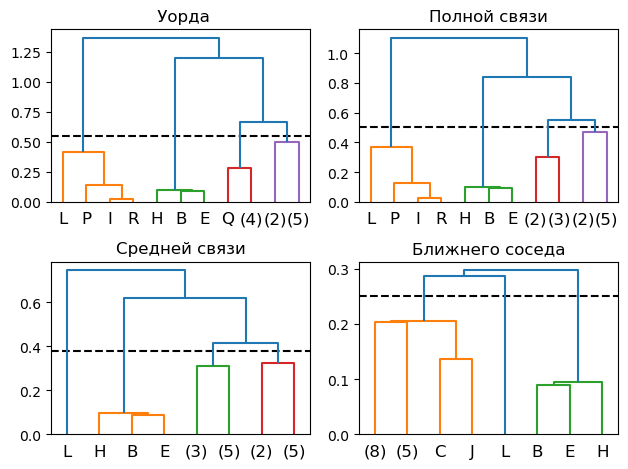

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

feature_labels_assets = ["Здания", "Машины и оборудование", \
    "Сооружения", "Транспортные средства"]
# feature_labels_assets = ["Здания", "Машины и оборудование", \
#     "Сооружения"]
X = data_to_cluster.loc[:, feature_labels_assets]
# scaler = MinMaxScaler()
# X["Всего основных фондов"] = scaler.fit_transform(X.loc[:, ["Всего основных фондов"]])

linkage_types = ['ward', 'complete', 'average', 'single']
cutoff_thresholds = [0.55, 0.5, 0.38, 0.25]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = [' Уорда', 'Полной связи', "Средней связи", "Ближнего соседа"]
linkage_labels = dict(zip(linkage_types, labels))

mpl.rcParams.update(mpl.rcParamsDefault)
hclust = dict()
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type, distance_threshold=0, n_clusters=None)
    clustering = model.fit(X)
    axs[axs_ind].set_title(linkage_labels[linkage_type])
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        clustering,
        truncate_mode="level",
        p=3,
        ax=axs[axs_ind], 
        labels=data_to_cluster["Код раздела"].to_list(),
        color_threshold = linkage_colors[linkage_type]
        # orientation='right'
        )
    
    hclust[linkage_type] = {
        "clustering": clustering,
        "linkage_matrix": linkage_matrix
    }
fig.tight_layout()
plt.show()


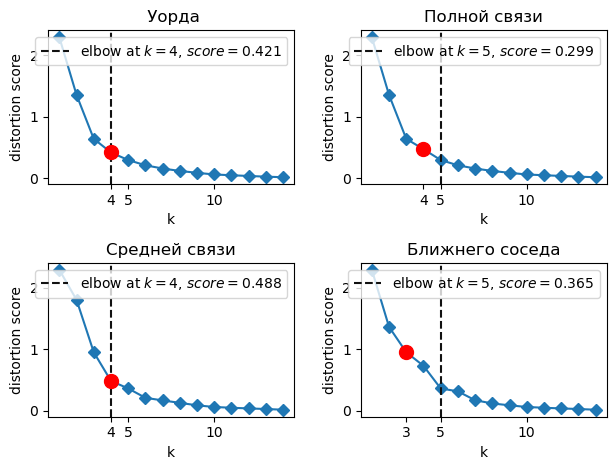

In [6]:
chosen_x = [4., 4., 4., 3.]
chosen_y = [0.421457, 0.475347, 0.487812, 0.953896]
scores = []
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for i, linkage_type, axs_ind in zip(range(4), linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type)
    visualizer = KElbowVisualizer(
        model,
        k=(1,15),
        ax=axs[axs_ind], 
        timings=False,
        title = linkage_labels[linkage_type],
        locate_elbow=True
        )
    visualizer.fit(X)
    visualizer.finalize()
    ticks = axs[axs_ind].get_xticks()
    ticks = np.append(ticks, chosen_x[i])
    axs[axs_ind].set_xticks(ticks)
    axs[axs_ind].plot([chosen_x[i]], [chosen_y[i]], \
        marker='o', ms=10, c='red')
    # if linkage_type == 'single':
    #     axs[axs_ind].axvline(x=linkage_chosen_k[linkage_type], color='red', \
    #         linestyle='dashdot')
    scores.append(visualizer.k_scores_)
fig.tight_layout()
# print()
plt.show()

In [7]:
df = pd.DataFrame(scores)
df = df.transpose().rename(columns=dict(zip(df.columns, labels)))
df = df.rename(index=dict(zip(df.index, range(1,df.shape[0]))))
pd.set_option('display.precision', 2)
# pd.reset_option('display.precision')
df.head()

,Уорда,Полной связи,Средней связи,Ближнего соседа
1,2.29,2.29,2.29,2.29
2,1.36,1.36,1.81,1.37
3,0.64,0.64,0.95,0.95
4,0.42,0.48,0.49,0.73
5,0.30,0.30,0.37,0.37


In [8]:
cutoff_thresholds = cutoff_thresholds
cluster_mapping = data_to_cluster.loc[:, :"Код раздела"]
# cluster_mapping = data_to_cluster
cluser_count = []
for linkage_type, t in zip(linkage_types, cutoff_thresholds):
    enum = fcluster(hclust[linkage_type]["linkage_matrix"], t=t, criterion='distance')
    model = hclust[linkage_type]["clustering"]
    # hclust[linkage_type]["score"] = metrics.silhouette_score(X, enum, metric='euclidean')
    cluster_mapping[linkage_type] = enum
    cluser_count.append(cluster_mapping.nunique()[linkage_type])
# ind = data_to_cluster[data_to_cluster['Код раздела'].isin(['A','B'])].index
# data_to_cluster = data_to_cluster.drop(ind)
# cluster_mapping.head()
# data_to_cluster.head()
# cluser_count

In [9]:
data_clustered = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered.to_csv('Данные/processed/clustering-mapping-structure.csv', index=False) 
data_clustered.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства,ward,complete,average,single
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",1.27e+07,0.34,0.33,0.13,0.06,3,4,2,1
1,B,Добыча полезных ископаемых,4.20e+07,0.07,0.19,0.70,0.03,2,2,1,3
2,C,Обрабатывающие производства,4.01e+07,0.22,0.50,0.23,0.03,4,4,3,1
3,D,"Обеспечение электрической энергией, газом и па...",2.93e+07,0.16,0.34,0.46,0.01,4,3,3,1
4,E,"Водоснабжение; водоотведение, организация сбор...",5.52e+06,0.12,0.11,0.71,0.04,2,2,1,3


In [10]:
data_clustered.loc[:, [*feature_labels_assets, "ward"]].groupby("ward").count()

,Здания,Машины и оборудование,Сооружения,Транспортные средства
ward,,,,
1,4,4,4,4
2,3,3,3,3
3,5,5,5,5
4,7,7,7,7


In [11]:
clu_num = 4
pd.set_option('display.max_colwidth', None)
# data_clustered[data_clustered["ward"] == clu_num].loc[:, ["Название раздела"]]
data_clustered[data_clustered["ward"] == clu_num]

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства,ward,complete,average,single
2,C,Обрабатывающие производства,4.01e+07,0.22,0.50,0.23,0.03,4,4,3,1
3,D,"Обеспечение электрической энергией, газом и паром; кондиционирование воздуха",2.93e+07,0.16,0.34,0.46,0.01,4,3,3,1
5,F,Строительство,4.60e+06,0.20,0.34,0.23,0.17,4,3,3,1
9,J,Деятельность в области информации и связи,8.94e+06,0.09,0.53,0.23,0.01,4,4,3,1
12,M,"Деятельность профессиональная, научная и техническая",1.04e+07,0.28,0.28,0.34,0.04,4,3,3,1
13,N,Деятельность административная и сопутствующие дополнительные услуги,4.34e+06,0.23,0.22,0.29,0.22,4,3,3,1
14,O,Государственное управление и обеспечение военной безопасности; социальное обеспечение,3.30e+07,0.28,0.13,0.38,0.05,4,3,3,1


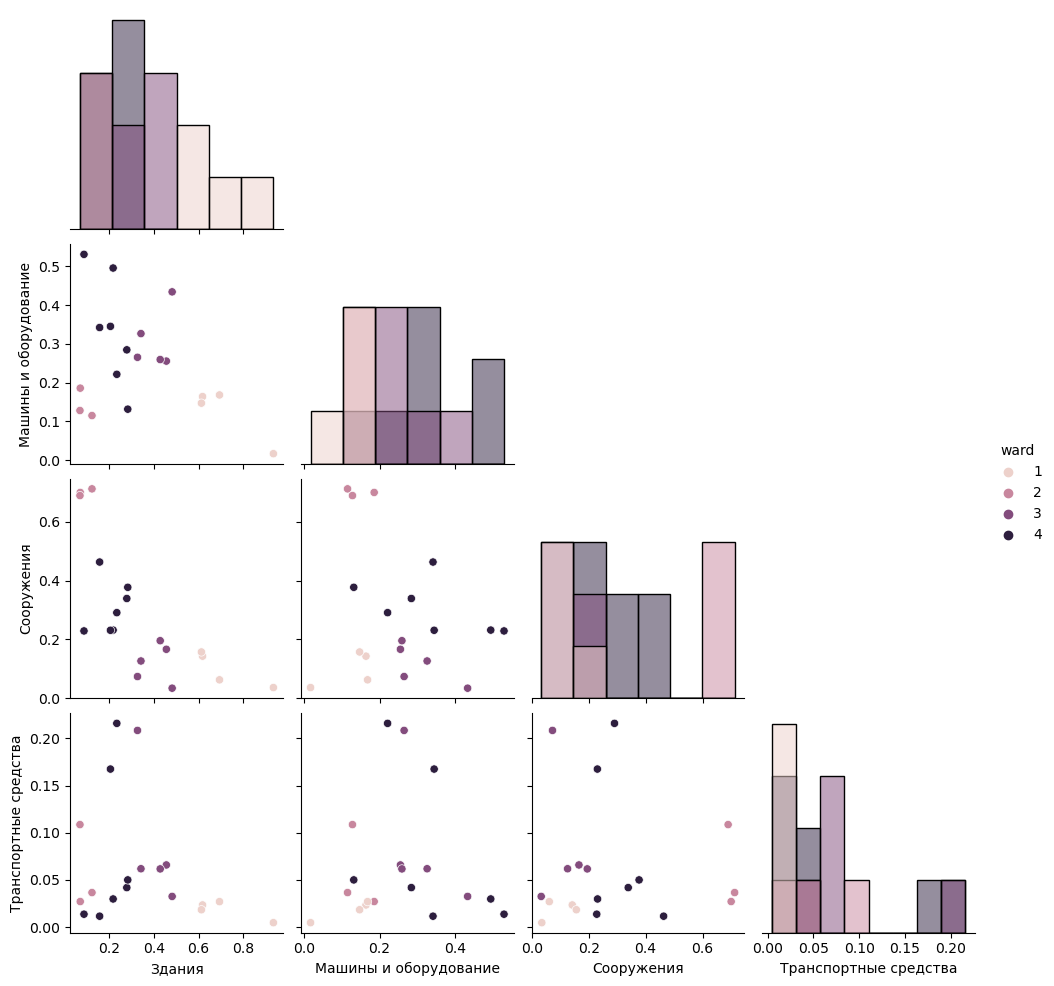

In [12]:
import warnings
warnings.filterwarnings('ignore')
# pd.reset_option('all')
sns.pairplot(data_clustered.loc[:, ["Здания", "Машины и оборудование", \
    "Сооружения", "Транспортные средства", "ward"]],corner=True, hue='ward', diag_kind='hist')
plt.show()

In [13]:
data_for_regr = pd.read_csv('Данные/processed/regression-data-v0.csv')
data_for_regr.head()
feature_labels_douglas = ['ROFA', 'K','L', 't']
# data_exprimental = data_for_regr.join(data_clustered, on='Код раздела', how='inner')
# data_exprimental.loc[:, 'ROFA':'t'].corr()

In [14]:
X = data_for_regr.loc[:, "ROFA":"L"]
std_arr = X.std().to_numpy()
print(std_arr)
err_rate = 0.1
# delta_arr = X.mean().to_numpy() * err_rate
delta_arr = std_arr / 2.5
N = X.shape[0]
print(N)

sample_sizes = [sample_size_repetitive(0.05, delta, N, std=std) \
    for delta, std in zip(delta_arr, std_arr)]
sample_sizes

[4.11275169e-02 3.94103165e+07 1.48824052e+08]
108


[16.27458538851528, 16.274585388515284, 16.27458538851528]

In [15]:
data_for_regr[[*feature_labels_douglas]].corr()

,ROFA,K,L,t
ROFA,1.00,-0.33,0.54,-0.16
K,-0.33,1.00,0.01,0.18
L,0.54,0.01,1.00,0.21
t,-0.16,0.18,0.21,1.00


In [16]:
linkage_type = 'ward'
# data_for_regr = data_for_regr[data_for_regr['Код раздела'] != 'G']
data_for_regr_cl = pd.merge(data_for_regr, cluster_mapping, 'inner', "Код раздела")
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
SSE_all = []
# print(data_for_regr_cl[['ln_ROFA', 'ln_K', 'ln_L', 't']].corr())
regr_metrics_all = []
for cluster_id in data_for_regr_cl[linkage_type].unique():
    regr_metrics = {}
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()

    n=X[X.columns[0]].count()
    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['obs_count'] = n

    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    regr_metrics['white_pvalue'] = white_pvalue

    SSE_i = (result_OLS.resid ** 2).sum()
    SSE_all.append(SSE_i)
    VIF_array = []
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_array.append(round(VIF, 2))

    # print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    # print(result_OLS.summary())    
    # print('-- White\'s test pvalue: ', white_pvalue)
    # print('-- VIF:', VIF_array)
    # print('-- SSE_i: ', round(SSE_i, 2))   

    # SSE_i = (result_OLS.resid ** 2).sum()
    # SSE_all.append(SSE_i)
    # print('-- SSE_i: ', round(SSE_i, 2))   

    VIF_array = []
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_array.append(round(VIF, 2))
        regr_metrics[f'VIF_x{exog_idx}'] = VIF
    # print('-- VIF:', VIF_array)
    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]
    hz, hz_pval, normal = multivariate_normality(regression.exog)
    regr_metrics['HZ'] = hz_pval
    regr_metrics_all.append(regr_metrics)

    X_resid = X.iloc[:, 1:]
    X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], hue='Код раздела', height=4)
    # # g.map(sns.regplot, color=".3", ci=None)
    # g.map(sns.scatterplot)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])
    # plt.show()

pd.set_option('display.float_format', lambda x: '%.4f' % x)
regr_metrics_all = pd.DataFrame(regr_metrics_all)
# print(regr_metrics_all)
regr_metrics_all
# plt.show()

,cluster_id,obs_count,white_pvalue,VIF_x1,VIF_x2,VIF_x3,JB,HZ
0,3,24,0.0664,1.6002,1.1659,1.7519,0.3318,0.0000
1,2,18,0.1053,28.8948,28.8565,1.0253,0.2886,0.0000
2,4,42,0.0009,1.1772,1.1957,1.0996,0.2682,0.0000
3,1,24,0.0328,1.1123,1.1415,1.0875,0.6764,0.0000


In [17]:
data_to_cluster = pd.read_csv("Данные/processed/regression-data-v0.csv")
data_clustered_full = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered_full = data_clustered_full.drop(columns=['Название раздела'])

In [18]:
# Check for multivariate normality
group_id = 3
d_clust_g3 = data_clustered_full[data_clustered_full['ward'] == group_id]

print(d_clust_g3.shape)
hz, pval, normal = multivariate_normality(d_clust_g3.loc[:, ['K', 'L', 't']])
print(normal)

(24, 9)
False


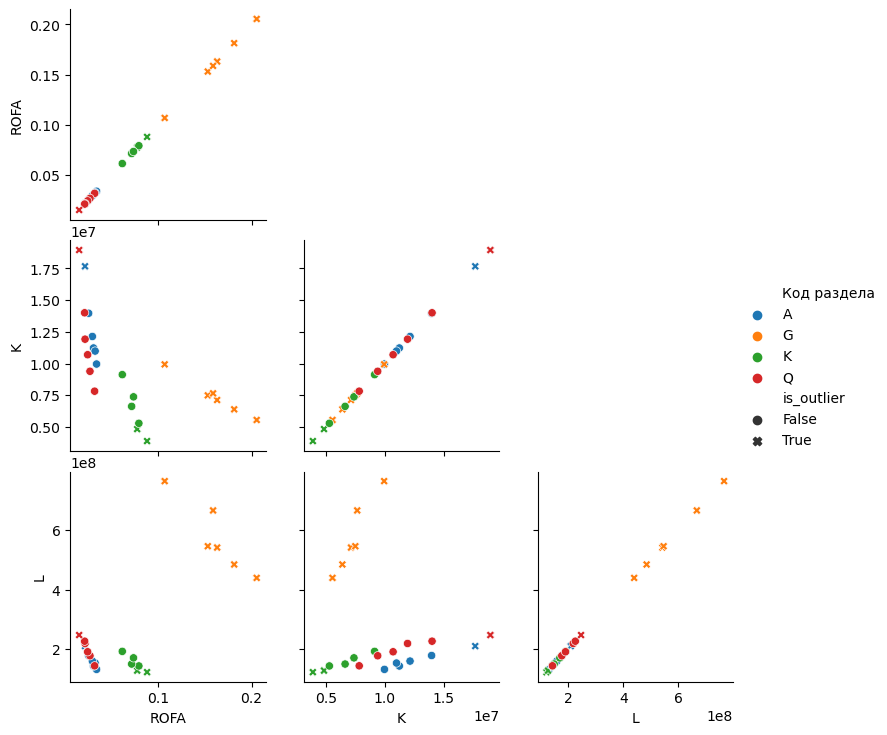

In [19]:
from help_funcs import isMahalanobisOutlier
is_outlier, squared_distances = isMahalanobisOutlier(d_clust_g3.loc[:, ['ROFA', 'K', 'L']]
                                  .to_numpy(), 0.55)
d_clust_g3['is_outlier'] = is_outlier
d_clust_g3['m_dist'] = squared_distances
d_clust_g3.loc[:, [ 'ROFA', 'K', 'L']]

# sns.histplot(d_clust_g3, x='m_dist')
# plt.show()
# sns.boxenplot(d_clust_g3, x='m_dist', k_depth='proportion', outlier_prop=0.5)
# plt.show()
# sns.boxenplot(d_clust_g3, x='m_dist', k_depth='trustworthy', trust_alpha=0.05)

g = sns.PairGrid(data=d_clust_g3.loc[:, ['ROFA', 'K', 'L']], corner=True)
g.map(sns.scatterplot, hue=d_clust_g3['Код раздела'], style=d_clust_g3['is_outlier'], 
      markers={True: 'X', False: 'o'})
g.add_legend()

2.0973209626492692e+18 2.0673740185932882e+18


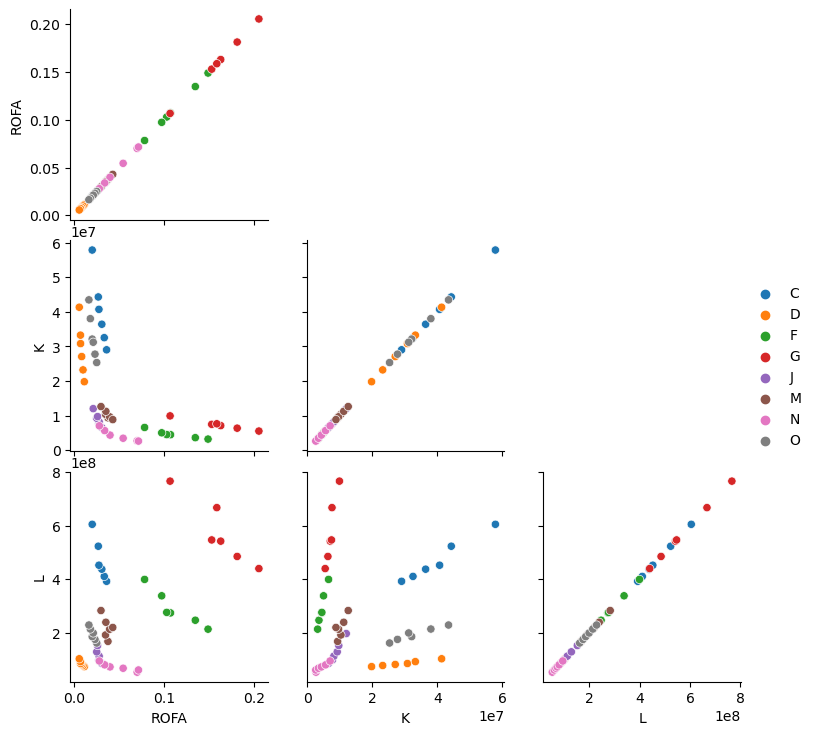

In [20]:
# SHUFFLE OUTLIERS
# Compute distortion first
from yellowbrick.cluster import distortion_score
data_shuffle1 = data_clustered_full.loc[:, ['Код раздела', *feature_labels_douglas, 'ward']].copy()
distortion1 = distortion_score(data_shuffle1[[*feature_labels_douglas]],
                               data_shuffle1['ward'])
data_shuffle2 = data_shuffle1.copy()
data_shuffle2.loc[data_shuffle2['Код раздела'] == 'G', 'ward'] = 4
distortion2 = distortion_score(data_shuffle2[[*feature_labels_douglas]],
                               data_shuffle2['ward'])
print(distortion1, distortion2)

data_shuffle2_cl4 = data_shuffle2[data_shuffle2['ward'] == 4]
g = sns.PairGrid(data=data_shuffle2_cl4.loc[:, ['ROFA', 'K', 'L']], corner=True)
g.map(sns.scatterplot, hue=data_shuffle2_cl4['Код раздела'],
      # style=data_shuffle2_cl4['is_outlier'], 
      markers={True: 'X', False: 'o'})
g.add_legend()

In [21]:
# REMOVE OUTLIERS
dc = data_clustered_full.loc[:, [*feature_labels_douglas, 'ward']].copy()
centroids = dc.groupby('ward').mean()
to_move = data_clustered_full[data_clustered_full["Код раздела"] == 'G'].loc[:, \
    [*feature_labels_douglas]]
distances = centroids.apply(lambda c: np.linalg.norm(c - to_move.mean()),
    axis='columns')
distances
# cluster_mapping.loc[cluster_mapping['Код раздела'] == 'G', 'ward'] = 1
# cluster_mapping.loc[cluster_mapping['Код раздела'] == 'G', 'ward'] = 3

ward
1   478279421.3802
2   432920491.2491
3   302943006.1093
4   366254861.9663
dtype: float64

In [76]:
# CORRECT HETEROSCEDASTISITY
linkage_type = 'ward'
data_for_regr_cl = data_shuffle2.copy()
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
SSE_all = []
regr_metrics_all = []
for cluster_id in [3, 2]:
    regr_metrics = {}

    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()

    def get_whites_e_regr(regression, k_most_corr=None, full=False):
        if full and k_most_corr:
            raise ValueError('either full or k_most_corr must be supplied')
        result_OLS = regression.fit()
        e = result_OLS.resid
        X = pd.DataFrame(data=regression.exog, columns=regression.exog_names,
                         index=e.index).iloc[:, 1:]
        X_resid = X.join(pd.DataFrame({"e": result_OLS.resid}))
        kendall_corr = X_resid.corr(method='kendall')
        most_corr_idx = kendall_corr.iloc[:-1, [-1]].sort_values(by='e', ascending=False,
                                                key=lambda series: series.abs()).index
        
        if full:
            X_white = X.copy()
            for i, colname_i in enumerate(X):
                for colname_j in X.columns[i:]:
                    colname_ij = colname_i + ' * ' + colname_j 
                    X_white[colname_ij] = X[colname_i] * X[colname_j]
        else:
            X_white = X[most_corr_idx[:k_most_corr]] ** 2
            X_white = X_white.rename(columns={col: col+'^2' for col in X_white.columns})
        X_white = sm.add_constant(X_white)
        whites_e_regr = sm.OLS(e ** 2, X_white, hasconst=True)

        print(whites_e_regr.fit().predict())
        return(whites_e_regr)

    
        x = np.sqrt(whites_e_regr.fit().predict())
        def diagonalize(x):
            assert x.ndims == 1
            x = np.atleast_2d(x).T
            N = x.shape[0]
            I = np.eye(N)
            P = np.zeros((N, N))
            for j in range(N):
                e = np.atleast_2d(I[j]).T
                e_nan_idx = np.argwhere(np.isnan(e))
                x_nan_idx = np.argwhere(np.isnan(x))
                P_j = ( e.T @ x ).item()
                P_j = P_j * e
                P_j = P_j @ e.T
                P += P_j
        return
    
    # whites_e_regr = get_whites_e_regr(regression, full=True)
    # result_white_OLS = whites_e_regr.fit()
    # print(result_white_OLS.summary())
    for k in range(1, X.shape[1]):
        regr_white_OLS = get_whites_e_regr(regression, k)
        result_white_OLS = regr_white_OLS.fit()
        print(result_white_OLS.summary())
    
    n=X[X.columns[0]].count()
    # print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    # print(result_OLS.summary())    
    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['obs_count'] = n

    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    # print('-- White\'s test pvalue: ', white_pvalue)
    regr_metrics['white_pvalue'] = white_pvalue

    # SSE_i = (result_OLS.resid ** 2).sum()
    # SSE_all.append(SSE_i)
    # print('-- SSE_i: ', round(SSE_i, 2))   

    VIF_array = []
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_array.append(round(VIF, 2))
        regr_metrics[f'VIF_x{exog_idx}'] = VIF
    # print('-- VIF:', VIF_array)
    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]
    hz, hz_pval, normal = multivariate_normality(regression.exog)
    regr_metrics['HZ'] = hz_pval

    regr_metrics_all.append(regr_metrics)

    # X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"],
    #                  hue='Код раздела', height=4)
    # # g.map(sns.regplot, color=".3", ci=None)
    # g.map(sns.scatterplot)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

regr_metrics_all = pd.DataFrame(regr_metrics_all)
# print(regr_metrics_all)
regr_metrics_all
# plt.show()

[0.00756805 0.00751384 0.00752374 0.00747843 0.00741395 0.0073047
 0.00798031 0.00788727 0.00784825 0.00774997 0.00770254 0.00760748
 0.00767648 0.00759471 0.00753587 0.00748646 0.00741267 0.00727181]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                  0.008141
Date:                Tue, 12 Mar 2024   Prob (F-statistic):              0.929
Time:                        12:36:02   Log-Likelihood:                 60.647
No. Observations:                  18   AIC:                            -117.3
Df Residuals:                      16   BIC:                            -115.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
         

,cluster_id,obs_count,white_pvalue,VIF_x1,VIF_x2,VIF_x3,JB,HZ
0,3,18,0.1632,2.4931,4.3191,2.6468,0.6454,0.0000
1,2,18,0.1053,28.8948,28.8565,1.0253,0.2886,0.0000


In [28]:
d_clust_g2 = data_for_regr_cl[data_for_regr_cl['ward'] == 2][
    ['ln_ROFA', 'ln_K', 'ln_L', 't']]
d_clust_g2.corr()
# sns.heatmap(d_clust_g2.corr(), fmt='.2f', annot=True)
# plt.show()

,ln_ROFA,ln_K,ln_L,t
ln_ROFA,1.0000,0.1661,0.0246,-0.3467
ln_K,0.1661,1.0000,0.9825,0.1567
ln_L,0.0246,0.9825,1.0000,0.1526
t,-0.3467,0.1567,0.1526,1.0000


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(d_clust_g2['ln_ROFA'], d_clust_g2['ln_K'], d_clust_g2['ln_L'])
plt.show()

In [ ]:
from scipy.stats import chi2
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

fig, ax = plt.subplots(1, 1)
df = 3
x = np.linspace(chi2.ppf(1e-10, df), chi2.ppf(0.999, df), 100)
rv = chi2(df)
d_clust_g3.loc[:, ['is_outlier', 'Код раздела']]
ax.plot(x, rv.pdf(x), c='black')

palette = sns.color_palette(n_colors=d_clust_g3['Код раздела'].nunique())
my_cmap = ListedColormap(palette.as_hex())
codes = d_clust_g3['Код раздела'].unique()
industry_colors = {code: (color if code == 'G' else 'grey') for code, color in zip(codes, my_cmap.colors)}
industry_linestyles = {code: ('dashed' if code == 'G' else 'solid') for code in codes}

# for x, ymax in zip(squared_distances, rv.pdf(squared_distances)):
for idx, obs in d_clust_g3.iterrows():
    ax.axvline(obs['m_dist'], ymax=rv.pdf(obs['m_dist'])*4.1,
               linestyle=industry_linestyles[obs['Код раздела']], c=industry_colors[obs['Код раздела']])

x2 = np.linspace(2.2, chi2.ppf(0.999, df), 80)
ax.fill_between(x2, rv.pdf(x2))
plt.margins(x=0, y=0)
fig.tight_layout()
plt.show()

In [ ]:
sns.pairplot(data_clustered_full.loc[:, 'ROFA':'ward'],
            corner=True, hue='ward', diag_kind='hist',
            palette=sns.color_palette(n_colors=cluser_count[0]))
plt.show()

In [ ]:
data_for_ANOVA = pd.merge(cluster_mapping, data_for_regr.loc[:, ["Код раздела", "ROFA"]], 'inner', 'Код раздела')
for linkage_type in linkage_types:
    groups = []
    for group_id in data_for_ANOVA[linkage_type].unique():
        groups.append(data_for_ANOVA["ROFA"][(data_for_ANOVA[linkage_type] == group_id)].to_numpy())
    res = stats.bartlett(*groups)
    print('bartlett', res.pvalue)
    res = stats.kruskal(*groups)
    print('kruskal', res.pvalue)